In [42]:
import pandas as pd
import numpy as np
import sys
from urllib.request import urlopen
from PIL import Image, ImageDraw

In [43]:
MQ_RESULTS_BASE_DIR = '/Users/darylwilding-mcbride/Downloads/190719_Hela_Ecoli_1to1_01_Slot1-1_1_1926-combined/txt'
SCAN_MAX = 910
SCAN_LENGTH_MINIMUM = SCAN_MAX * 0.01  # filter out the small-extent features
MIN_ISOTOPE_CORRELATION = 0.9
DELTA_MZ = 1.003355     # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4


In [44]:
PIXELS_X = 910
PIXELS_Y = 910  # equal to the number of scan lines
PIXELS_PER_BIN = 1
MZ_MIN = 100.0
MZ_MAX = 1700.0
SCAN_MAX = PIXELS_Y
SCAN_MIN = 1
MZ_PER_TILE = 18.0
MZ_BIN_WIDTH = MZ_PER_TILE / (PIXELS_X * PIXELS_PER_BIN)
TILES_PER_FRAME = int((MZ_MAX - MZ_MIN) / MZ_PER_TILE)
tile_idx = 33

In [45]:
allpeptides_df = pd.read_csv('{}/allPeptides.txt'.format(MQ_RESULTS_BASE_DIR), sep='\t')

In [46]:
allpeptides_df.rename(columns={'Number of isotopic peaks':'isotope_count', 'm/z':'mz', 'Number of data points':'number_data_points', 'Intensity':'intensity', 'Ion mobility index':'scan', 'Ion mobility index length':'scan_length', 'Ion mobility index length (FWHM)':'scan_length_fwhm', 'Retention time':'rt', 'Retention length':'rt_length', 'Retention length (FWHM)':'rt_length_fwhm', 'Charge':'charge_state', 'Number of pasef MS/MS':'number_pasef_ms2_ids', 'Isotope correlation':'isotope_correlation'}, inplace=True)

In [47]:
# filter out rubbish values
allpeptides_df = allpeptides_df[
                    allpeptides_df.intensity.notnull() &
                    (allpeptides_df.isotope_correlation >= MIN_ISOTOPE_CORRELATION) &
                    (allpeptides_df.scan_length > SCAN_LENGTH_MINIMUM) &
                    (allpeptides_df.charge_state > 1)
                ].copy()

In [48]:
len(allpeptides_df)

92548

In [49]:
allpeptides_df['rt_secs'] = allpeptides_df.rt * 60
allpeptides_df['rt_lower_secs'] = (allpeptides_df.rt - (allpeptides_df.rt_length / 2)) * 60
allpeptides_df['rt_upper_secs'] = (allpeptides_df.rt + (allpeptides_df.rt_length / 2)) * 60
allpeptides_df['rt_fwhm_lower_secs'] = (allpeptides_df.rt - (allpeptides_df.rt_length_fwhm / 2)) * 60
allpeptides_df['rt_fwhm_upper_secs'] = (allpeptides_df.rt + (allpeptides_df.rt_length_fwhm / 2)) * 60

In [50]:
allpeptides_df['rt_lower_2sd'] = (allpeptides_df.rt - (allpeptides_df.rt_length_fwhm / 2.355 * 2)) * 60
allpeptides_df['rt_upper_2sd'] = (allpeptides_df.rt + (allpeptides_df.rt_length_fwhm / 2.355 * 2)) * 60

In [51]:
# parameters for tile 33 of frame 2019
mz_lower = MZ_MIN + (tile_idx * MZ_PER_TILE)
mz_upper = mz_lower + MZ_PER_TILE
frame_id = 1944
retention_time_secs = 206.296694
tile_idx = 33
tile_idx_base = tile_idx * PIXELS_X

In [52]:
# filter the features so it only includes those appearing in the selected frame
frame_features_df = allpeptides_df[(retention_time_secs >= allpeptides_df.rt_lower_2sd) & (retention_time_secs <= allpeptides_df.rt_upper_2sd)].copy()


In [53]:
len(frame_features_df)

285

In [54]:
mz_bins = np.arange(start=MZ_MIN, stop=MZ_MAX+MZ_BIN_WIDTH, step=MZ_BIN_WIDTH)  # go slightly wider to accommodate the maximum value


In [55]:
tile_url = 'http://spectra-server-lb-1653892276.ap-southeast-2.elb.amazonaws.com/tile/33/frame/1944'
img = Image.open(urlopen(tile_url))
draw = ImageDraw.Draw(img)

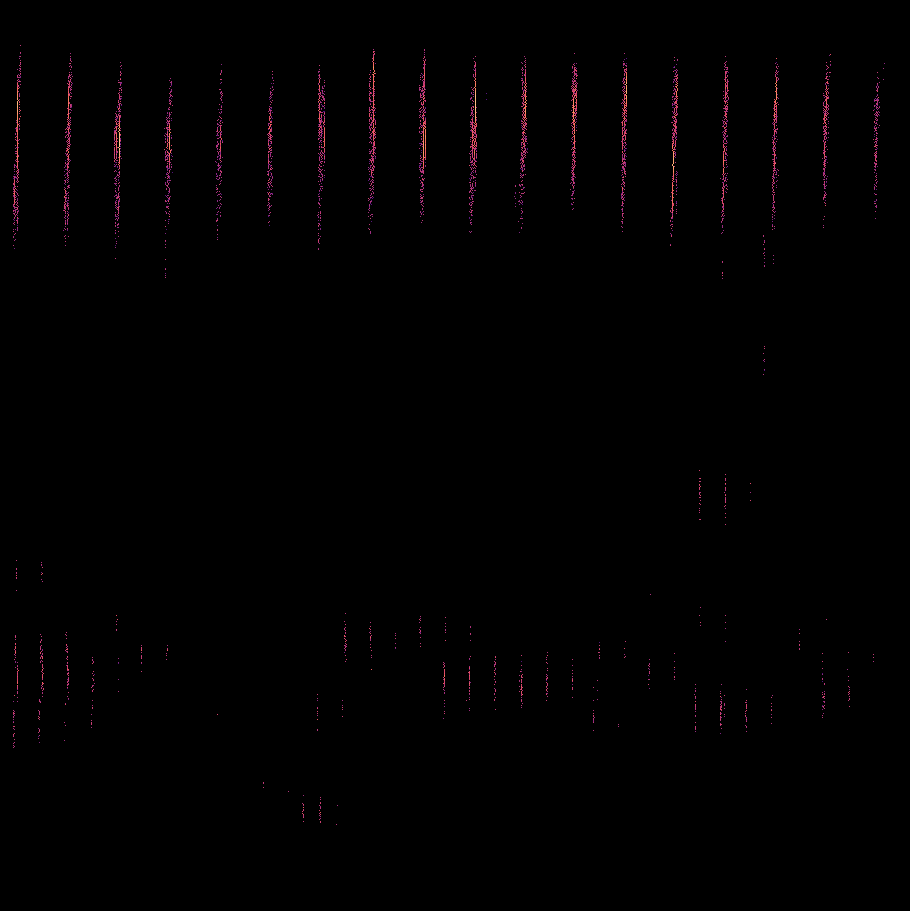

In [56]:
img

In [57]:
isotope_gap_pixels = 10

In [58]:
# calculate the MQ feature rectangles
for r in zip(frame_features_df.charge_state,frame_features_df.isotope_count,frame_features_df.mz,frame_features_df.scan,frame_features_df.scan_length):
    charge_state = int(r[0])
    isotope_count = int(r[1])
    mq_feature_mz = r[2]
    mq_feature_scan = int(r[3])
    mq_feature_scan_length = int(r[4])

    expected_isotope_spacing_mz = DELTA_MZ / charge_state

    # find the bin edges for the feature's mz
    binned_mz_idx_lower = int(np.digitize(mq_feature_mz, mz_bins))-1
    binned_mz_idx_upper = int(np.digitize(mq_feature_mz + ((isotope_count-1) * expected_isotope_spacing_mz), mz_bins))
    x = (binned_mz_idx_lower - tile_idx_base) - isotope_gap_pixels
    w = (binned_mz_idx_upper - binned_mz_idx_lower) + (2 * isotope_gap_pixels)

    rect_scan = mq_feature_scan
    rect_scan_delta = mq_feature_scan_length / 2
    y = int(rect_scan - rect_scan_delta)
    h = mq_feature_scan_length
    
    # draw the rectangle
    draw.rectangle(xy=[(x, y), (x+w, y+h)], fill=None, outline='red')

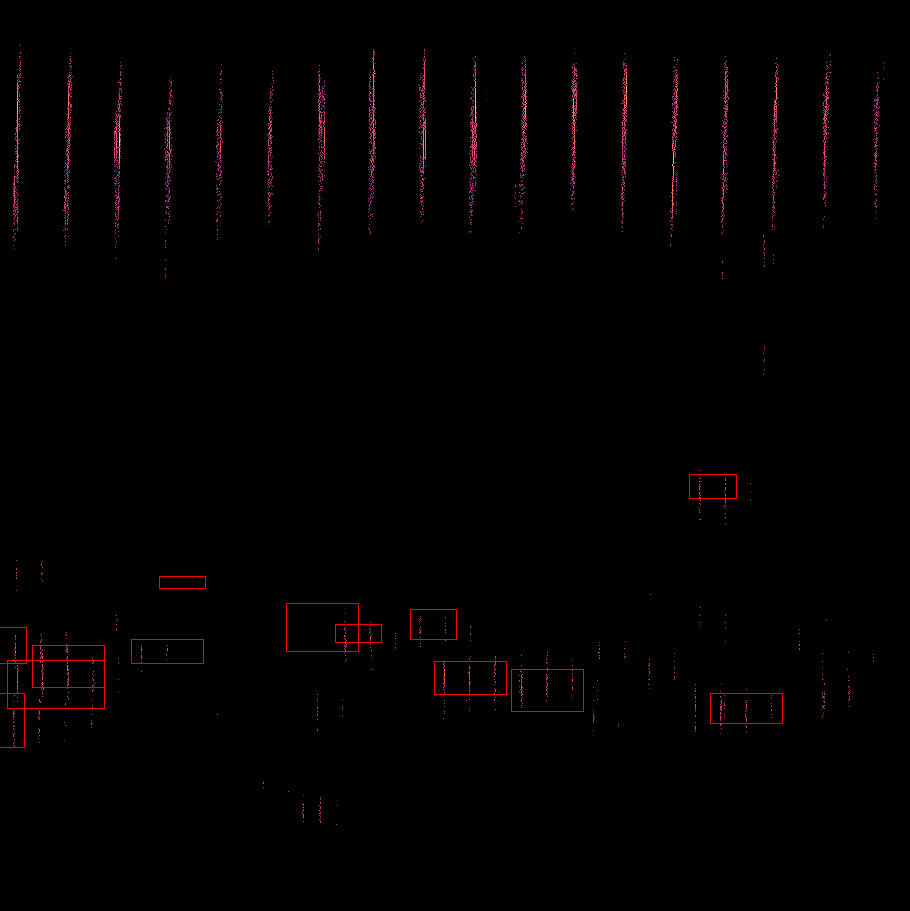

In [59]:
img

In [60]:
img.save('/Users/darylwilding-mcbride/Downloads/frame-1944-tile-33-mq-labels.png')